In [1]:
from catboost import CatBoostRegressor, Pool
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

pd.options.display.max_columns = 200

In [2]:
def read_file(path):
    df = pd.read_excel(path)
    df.columns = df.iloc[4]
    df = df.iloc[5:][df.columns[:-1]]

    columns = df.columns.tolist()

    columns[3] = 'продажи'
    columns[16] = 'заболеваемость'
    columns[33] = 'ТВ реклама, руб'
    columns[35] = 'интернет реклама, руб'
    columns[51] = 'wordstat'
    
    df.columns = columns
    df.loc[df['неделя'] == 53, 'неделя'] = 52

    return df

df = read_file('data/train.xlsx')
df.loc[df['неделя']==53, 'неделя'] = 52

In [3]:
def create_features(cur_df):
    df = cur_df.copy(deep=True)

    week_info = df.groupby('неделя')['заболеваемость'].agg(['sum', 'count'])
    week_info.columns = [f'week_{x}' for x in week_info.columns]

    df = df.merge(week_info, how='left', right_index=True, left_on='неделя')
    df['week_sum'] -= df['заболеваемость']
    df['week_count'] -= 1
    df['feature_mean_week'] = df['week_sum'] / df['week_count']
    df['feature_mean_week_norm'] = df['feature_mean_week'] / df['заболеваемость']

    df['feature_week'] = df['неделя']

    # for i in range(1, 16, 4):
    #     df[f'feature_month_diff_{i}'] = df['value'].shift(i) / df['value'].shift(i+4)

    for i in range(28):
        df[f'target_{i+1}'] = df['заболеваемость'].shift(-i) / df['заболеваемость'].shift(1)

    for i in [7, 13, 20]:
        df[f'feature_big_diff_{i}_weeks'] = df['заболеваемость'].shift(1) / df['заболеваемость'].shift(i)

    bad_cols = [col for col in df.columns if 'feature' not in col and 'target' not in col]
    df.drop(bad_cols, axis=1, inplace=True)
    
    return df

df = create_features(df)
# df = df.dropna().reset_index(drop=True)

In [4]:
df = df[df['target_1'].notna()].reset_index(drop=True)
df = df.loc[20:].reset_index(drop=True)

In [5]:
df = df[df['target_28'].notna()]

In [6]:
test_size = 0.3

train_data, valid_data = df[:int(len(df) * (1-test_size))], df[int(len(df) * (1-test_size)):]

In [10]:
all_models = []
all_metrics = []
all_preds = []
for i in range(1, 29):
    print(f'Предсказываение на {i} недель вперед')

    X_train, y_train = train_data.drop([x for x in train_data.columns if 'target' in x], axis=1), train_data[f'target_{i}']
    X_valid, y_valid = valid_data.drop([x for x in valid_data.columns if 'target' in x], axis=1), valid_data[f'target_{i}']

    model = CatBoostRegressor(
        depth=2,
        learning_rate=0.03,
        iterations=3000,
        loss_function='MAPE',
        eval_metric='MAPE',
        custom_metric=['R2'],

        random_state=42,
        thread_count=4
    )

    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=False)
    all_models.append(model)

    preds = model.predict(X_valid)
    all_preds.append(preds)

    r2_metric = metrics.r2_score(y_valid, preds)
    mape_metric = metrics.mean_absolute_percentage_error(y_valid, preds)
    all_metrics.append([r2_metric, mape_metric])

    print(f'R2: {round(r2_metric, 5)}')
    print(f'MAPE: {round(mape_metric, 5)}')
    
    print()

Предсказываение на 1 недель вперед
R2: 0.18294
MAPE: 0.13505

Предсказываение на 2 недель вперед
R2: 0.33437
MAPE: 0.20586

Предсказываение на 3 недель вперед
R2: 0.28502
MAPE: 0.25115

Предсказываение на 4 недель вперед
R2: 0.27566
MAPE: 0.29125

Предсказываение на 5 недель вперед
R2: 0.45823
MAPE: 0.29874

Предсказываение на 6 недель вперед
R2: 0.50399
MAPE: 0.34145

Предсказываение на 7 недель вперед
R2: 0.54974
MAPE: 0.31575

Предсказываение на 8 недель вперед
R2: 0.53422
MAPE: 0.32853

Предсказываение на 9 недель вперед
R2: 0.58005
MAPE: 0.27497

Предсказываение на 10 недель вперед
R2: 0.69682
MAPE: 0.23989

Предсказываение на 11 недель вперед
R2: 0.78578
MAPE: 0.19106

Предсказываение на 12 недель вперед
R2: 0.7973
MAPE: 0.20644

Предсказываение на 13 недель вперед
R2: 0.88814
MAPE: 0.19504

Предсказываение на 14 недель вперед
R2: 0.87522
MAPE: 0.20884

Предсказываение на 15 недель вперед
R2: 0.86949
MAPE: 0.20362

Предсказываение на 16 недель вперед
R2: 0.84885
MAPE: 0.21776

Пр

In [15]:
pd.DataFrame({
    'name': X_train.columns,
    'imp': all_models[0].get_feature_importance()
}).sort_values('imp', ascending=False)

,name,imp
2,feature_week,41.925796
5,feature_big_diff_20_weeks,21.535299
0,feature_mean_week,14.605232
3,feature_big_diff_7_weeks,8.929691
1,feature_mean_week_norm,8.031141
4,feature_big_diff_13_weeks,4.972841


In [12]:
print(f'R2: {round(np.mean([x[0] for x in all_metrics]), 5)}')
print(f'MAPE: {round(np.mean([x[1] for x in all_metrics]), 5)}')

R2: 0.62775
MAPE: 0.30145


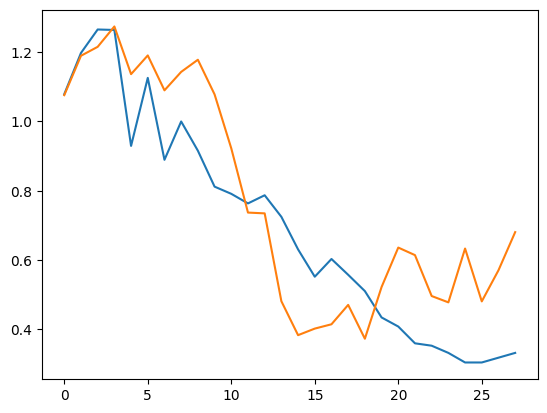

In [14]:
idx = 54

preds = [all_models[i].predict(X_valid)[idx] for i in range(28)]

plt.plot([valid_data.iloc[idx][f'target_{i}'] for i in range(1, 29)])
plt.plot(preds)